<center><h1>Facial Keypoint Detection using CNN :</h1></center>





# Load the Data :

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import Network
from models import Net

# Reload if any changes occur to the model in model.py
%load_ext autoreload
%autoreload 2

In [2]:
net = Net()
net.load_state_dict(torch.load('./keypoints_model_test.pt'))
print(net)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (batchNorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=15488, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Li

## Data Transforms

In this part we will create a transformed dataset using the classes defined in data_load.py, the transforms are optional and can be groupped using a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) from torchvision.transforms

**The transformations consist of :**

>>1. Rescaling and/or cropping the data to get a square image (prefered).
2. Normalizing the images and keypoints (RGB images to [0,1] Grascale and  keypoints into a range of [-1, 1])
3. Convert images into tensors.



In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor


data_transform = transforms.Compose([Rescale(230),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [8]:
# Create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./train-test-data/training_frames_keypoints.csv',
                                             root_dir='./train-test-data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# Iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Create Batches of Data:

In this step we will use the Dataloader of pytorch [this documentation](http://pytorch.org/docs/master/data.html). to create batches of the data and shuffle it

Note about Batchsize: a good batch size in general have values between 32-256, a large batch size can result in running out of  memory and the training will crash, a small batchsize like 16 or 8 can result in a poor model performance (at least in this application)

In [9]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


# Load and create the Test Dataset:

In [11]:
# Create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./train-test-data/test_frames_keypoints.csv',
                                             root_dir='./train-test-data/test/',
                                             transform=data_transform)

# load test data in batches
batch_size = 64

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

In [12]:
# test the model on a batch of test images

def net_sample_output():
    
    """
    Return: test image, predicted keypoints, ground truth keypoints.
    """
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [13]:
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


## Visualize the predicted keypoints

**`show_all_keypoints` : displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).**

In [14]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:,0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


# Un-transformation

**This function will undo all the transformations applied to a batch of images and the corresponding keypoints**

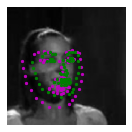

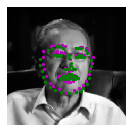

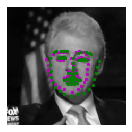

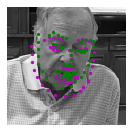

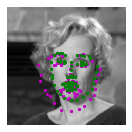

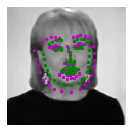

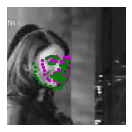

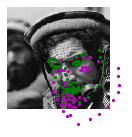

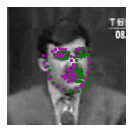

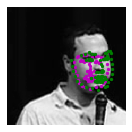

In [21]:

def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(25,15))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

# Training

## Loss function
**Various Loss functions can be used in this regression problem.For example : MSE, L1 loss, Smooth L1 Loss Check the link [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).**

## Train:

**Train_net function will train the model and outputs the history of the loss function.**

In [16]:
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(),lr=0.001)


In [17]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    loss_history=0.0
    for epoch in range(n_epochs):  
        
        running_loss = 0.0
        epoch_loss=0.0
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            epoch_loss+=loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
        
        loss_history=epoch_loss
        print("Epoch {} Finished!,AVG. Loss : {}".format(epoch+1,epoch_loss))
        
    return loss_history
        
    print('Finished Training')


In [ ]:
loss=[]
n_epochs = 20
loss.append(train_net(n_epochs))

# Test data



In [ ]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())

print(test_outputs.data.size())
print(gt_pts.size())

In [ ]:
# Visualize the predicted and ground truth keypoints.
visualize_output(test_images, test_outputs, gt_pts)

# Save Model:

In [ ]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_test.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

# Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

[[-0.07819629 -0.16193603 -0.19981994 -0.02917067 -0.14923254]
 [ 0.08934449  0.03539993  0.06732634  0.11691364 -0.18507296]
 [-0.1259183  -0.04629984 -0.07444161  0.13494918 -0.15338404]
 [ 0.12655237  0.04197789 -0.03532367  0.02725135 -0.05616785]
 [-0.14431372  0.08952121 -0.08416951 -0.04288858  0.13405095]]
(5, 5)


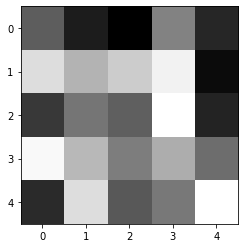

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')
